# 交流潮流优化模型对比
本 notebook 展示如何对比 SOCP-AC-OPF 和 AC-OPF 两个模型
本文档包含两个模型的数学描述和对比分析：
1. **SOCP-AC-OPF**：使用二阶锥松弛的凸优化模型
2. **AC-OPF**：使用等式约束的非凸优化模型
关键差异在约束 (5)：
- SOCP: $(2P)^2 + (2Q)^2 + (l-v)^2 \leq (l+v)^2$
- AC: $P^2 + Q^2 = l \cdot v$
---

## 1. SOCP-AC-OPF 模型（二阶锥松弛模型）

### 1.1 优化模型

$$
\begin{align}
\min_{P_{t,i,j}, Q_{t,i,j}, l_{t,i,j}, v_{t,i}, p_{t,i}, q_{t,i}, P_{g,t,g}, Q_{g,t,g}, P_{DR,t,dr}} \quad & \sum_{t=0}^{T-1} \sum_{(i,j) \in E} l_{t,i,j} \\
\text{s.t.} \quad \\
& v_{t,0} = 1.0, \quad \forall t \in \{0,1,\ldots,T-1\} \tag{1} \\
\\
& p_{t,j} = \sum_{g \in G_j} P_{g,t,g} + \sum_{dr \in DR_j} P_{DR,t,dr} + P_{d,t,j}, \quad \forall t, j \in N \tag{2a} \\
\\
& q_{t,j} = \sum_{g \in G_j} Q_{g,t,g} + Q_{d,t,j}, \quad \forall t, j \in N \tag{2b} \\
\\
& p_{t,j} = \sum_{(j,k) \in E} P_{t,j,k} - \sum_{(i,j) \in E} \left( P_{t,i,j} - r_{ij} \cdot l_{t,i,j} \right), \quad \forall t, j \in N \tag{3a} \\
\\
& q_{t,j} = \sum_{(j,k) \in E} Q_{t,j,k} - \sum_{(i,j) \in E} \left( Q_{t,i,j} - x_{ij} \cdot l_{t,i,j} \right), \quad \forall t, j \in N \tag{3b} \\
\\
& v_{t,j} = v_{t,i} - 2\left( r_{ij} P_{t,i,j} + x_{ij} Q_{t,i,j} \right) + \left( r_{ij}^2 + x_{ij}^2 \right) l_{t,i,j}, \quad \forall t, (i,j) \in E \tag{4} \\
\\
& \left(2P_{t,i,j}\right)^2 + \left(2Q_{t,i,j}\right)^2 + \left(l_{t,i,j} - v_{t,i}\right)^2 \leq \left(l_{t,i,j} + v_{t,i}\right)^2, \quad \forall t, (i,j) \in E \tag{5-SOCP} \\
\\
& P_{g,\min}(t) \leq P_{g,t,g} \leq P_{g,\max}(t), \quad \forall t, g \in G \tag{6} \\
\\
& P_{DR,\min}(t) \leq P_{DR,t,dr} \leq P_{DR,\max}(t), \quad \forall t, dr \in DR \tag{7} \\
\\
& V_{\min}^2 \leq v_{t,i} \leq V_{\max}^2, \quad \forall t, i \in N \tag{8} \\
\\
& -2.5 \leq P_{t,i,j} \leq 2.5, \quad \forall t, (i,j) \in E \tag{9a} \\
\\
& -2.5 \leq Q_{t,i,j} \leq 2.5, \quad \forall t, (i,j) \in E \tag{9b} \\
\\
& 0 \leq l_{t,i,j} \leq 2.5, \quad \forall t, (i,j) \in E \tag{9c}
\end{align}
$$

**约束 (5-SOCP) 说明**：这是对原始非凸约束 $l_{t,i,j} \cdot v_{t,i} = P_{t,i,j}^2 + Q_{t,i,j}^2$ 的**凸松弛**（使用不等号 $\leq$），使得整个问题成为凸优化问题，可以高效求解。

【算力中心子模型约束（对每个时段 t 生效）】

为得到 $p^{dc}_{k,t}$，引入算力中心子模型，用于描述业务分配、积压与 QoS 约束，并通过用电映射得到等效电功率负荷。子模型为新增约束集合，不影响原 BFM 结构。 

- 业务源集合 $S$（本实现可取单源汇总情形 $S=\{1\}$）
- 算力中心集合 $K$（本实现接入两个算力中心）

(DC-3) 处理量定义：
$$
p_{k,t}=\sum_{s\in S}x_{s,k,t},\quad \forall k\in K,\; t
\tag{DC-3}
$$

(DC-4) 容量约束：
$$
p_{k,t}\le C_k,\quad \forall k\in K,\; t
\tag{DC-4}
$$

(DC-5) 容量上限：
$$
0\le C_k\le \bar C_k,\quad \forall k\in K
\tag{DC-5}
$$

(DC-6)(DC-7) 积压动态与工作守恒：
$$
B_{s,t}=B_{s,t-1}+d_{s,t}-\sum_{k\in K}x_{s,k,t},\quad \forall s\in S,\; t\ge 1
\tag{DC-6}
$$

$$
\sum_{k\in K}x_{s,k,t}\le d_{s,t}+B_{s,t-1},\quad \forall s\in S,\; t\ge 1
\tag{DC-7}
$$

时段 $t=0$ 的初始条件对应为：
$$
B_{s,0}=B_{s,0}^{(\mathrm{given})}+d_{s,0}-\sum_{k\in K}x_{s,k,0},\quad 
\sum_{k\in K}x_{s,k,0}\le d_{s,0}+B_{s,0}^{(\mathrm{given})}
\tag{DC-6/7-Init}
$$

(DC-8) 终端积压限制：
$$
B_{s,T-1}\le B^{end}_s,\quad \forall s\in S
\tag{DC-8}
$$

(DC-11) QoS 合并时延约束（网络时延 + 排队等待上界）：
$$
\sum_{k\in K}\tau_{s,k}\,x_{s,k,t}+\gamma_s\,B_{s,t}\le L^{\max}_{s,t}\,d_{s,t},
\quad \forall s\in S,\; t
\tag{DC-11}
$$

(DC-12) 用电映射约束：
$$
p^{dc}_{k,t}=\eta_k\,p_{k,t},\quad \forall k\in K,\; t
\tag{DC-12}
$$


---

## 2. AC-OPF 模型（等式约束模型）

### 2.1 优化模型

$$
\begin{align}
\min_{P_{t,i,j}, Q_{t,i,j}, l_{t,i,j}, v_{t,i}, p_{t,i}, q_{t,i}, P_{g,t,g}, Q_{g,t,g}, P_{DR,t,dr}} \quad & \sum_{t=0}^{T-1} \sum_{(i,j) \in E} l_{t,i,j} \\
\text{s.t.} \quad \\
& v_{t,0} = 1.0, \quad \forall t \in \{0,1,\ldots,T-1\} \tag{1} \\
\\
& p_{t,j} = \sum_{g \in G_j} P_{g,t,g} + \sum_{dr \in DR_j} P_{DR,t,dr} + P_{d,t,j}, \quad \forall t, j \in N \tag{2a} \\
\\
& q_{t,j} = \sum_{g \in G_j} Q_{g,t,g} + Q_{d,t,j}, \quad \forall t, j \in N \tag{2b} \\
\\
& p_{t,j} = \sum_{(j,k) \in E} P_{t,j,k} - \sum_{(i,j) \in E} \left( P_{t,i,j} - r_{ij} \cdot l_{t,i,j} \right), \quad \forall t, j \in N \tag{3a} \\
\\
& q_{t,j} = \sum_{(j,k) \in E} Q_{t,j,k} - \sum_{(i,j) \in E} \left( Q_{t,i,j} - x_{ij} \cdot l_{t,i,j} \right), \quad \forall t, j \in N \tag{3b} \\
\\
& v_{t,j} = v_{t,i} - 2\left( r_{ij} P_{t,i,j} + x_{ij} Q_{t,i,j} \right) + \left( r_{ij}^2 + x_{ij}^2 \right) l_{t,i,j}, \quad \forall t, (i,j) \in E \tag{4} \\
\\
& P_{t,i,j}^2 + Q_{t,i,j}^2 = l_{t,i,j} \cdot v_{t,i}, \quad \forall t, (i,j) \in E \tag{5-AC} \\
\\
& P_{g,\min}(t) \leq P_{g,t,g} \leq P_{g,\max}(t), \quad \forall t, g \in G \tag{6} \\
\\
& P_{DR,\min}(t) \leq P_{DR,t,dr} \leq P_{DR,\max}(t), \quad \forall t, dr \in DR \tag{7} \\
\\
& V_{\min}^2 \leq v_{t,i} \leq V_{\max}^2, \quad \forall t, i \in N \tag{8} \\
\\
& -2.5 \leq P_{t,i,j} \leq 2.5, \quad \forall t, (i,j) \in E \tag{9a} \\
\\
& -2.5 \leq Q_{t,i,j} \leq 2.5, \quad \forall t, (i,j) \in E \tag{9b} \\
\\
& 0 \leq l_{t,i,j} \leq 2.5, \quad \forall t, (i,j) \in E \tag{9c}
\end{align}
$$

**约束 (5-AC) 说明**：这是原始的**等式约束**（使用 $=$），表示支路功率的平方和等于电流平方与电压平方的乘积。这个约束是**非凸的**，使得整个问题成为非凸优化问题（NP-hard）。

【AC 模型下的算力中心耦合与子模型约束】
(DC-3) 处理量定义：
$$
p_{k,t}=\sum_{s\in S}x_{s,k,t},\quad \forall k\in K,\; t
\tag{DC-3}
$$

(DC-4) 容量约束：
$$
p_{k,t}\le C_k,\quad \forall k\in K,\; t
\tag{DC-4}
$$

(DC-5) 容量上限：
$$
0\le C_k\le \bar C_k,\quad \forall k\in K
\tag{DC-5}
$$

(DC-6)(DC-7) 积压动态与工作守恒：
$$
B_{s,t}=B_{s,t-1}+d_{s,t}-\sum_{k\in K}x_{s,k,t},\quad \forall s\in S,\; t\ge 1
\tag{DC-6}
$$

$$
\sum_{k\in K}x_{s,k,t}\le d_{s,t}+B_{s,t-1},\quad \forall s\in S,\; t\ge 1
\tag{DC-7}
$$

时段 $t=0$ 的初始条件对应为：
$$
B_{s,0}=B_{s,0}^{(\mathrm{given})}+d_{s,0}-\sum_{k\in K}x_{s,k,0},\quad 
\sum_{k\in K}x_{s,k,0}\le d_{s,0}+B_{s,0}^{(\mathrm{given})}
\tag{DC-6/7-Init}
$$

(DC-8) 终端积压限制：
$$
B_{s,T-1}\le B^{end}_s,\quad \forall s\in S
\tag{DC-8}
$$

(DC-11) QoS 合并时延约束（网络时延 + 排队等待上界）：
$$
\sum_{k\in K}\tau_{s,k}\,x_{s,k,t}+\gamma_s\,B_{s,t}\le L^{\max}_{s,t}\,d_{s,t},
\quad \forall s\in S,\; t
\tag{DC-11}
$$

(DC-12) 用电映射约束：
$$
p^{dc}_{k,t}=\eta_k\,p_{k,t},\quad \forall k\in K,\; t
\tag{DC-12}
$$


AC-OPF 模型的算力中心接入方式与 SOCP 模型完全一致：节点有功注入采用 (2a-DC) 形式（在 (2a) 基础上扣除算力中心等效负荷），并同时施加算力中心子模型约束 (DC-3)～(DC-12)。因此两个模型在“算力中心负荷建模”方面是一致的，差异仍仅体现在 (5-SOCP)/(5-AC) 的松弛与等式关系。


---

## 3. 两个模型的关键差异

### 3.1 约束 (5) 的差异

| 模型 | 约束形式 | 数学表达式 | 问题性质 |
|------|---------|-----------|---------|
| **SOCP-AC-OPF** | 二阶锥不等式 | $(2P)^2 + (2Q)^2 + (l-v)^2 \leq (l+v)^2$ | 凸优化 |
| **AC-OPF** | 等式约束 | $P^2 + Q^2 = l \cdot v$ | 非凸优化 |

### 3.2 等价性说明

二阶锥约束展开后：
$$
\begin{align}
(2P)^2 + (2Q)^2 + (l-v)^2 &\leq (l+v)^2 \\
4P^2 + 4Q^2 + l^2 - 2lv + v^2 &\leq l^2 + 2lv + v^2 \\
4P^2 + 4Q^2 &\leq 4lv \\
P^2 + Q^2 &\leq lv
\end{align}
$$

因此：
- **SOCP 模型**使用 $P^2 + Q^2 \leq lv$（松弛）
- **AC 模型**使用 $P^2 + Q^2 = lv$（精确）

### 3.3 松弛间隙定义

定义**松弛量** (slack) 为：
$$
\text{slack}_{t,i,j} = l_{t,i,j} \cdot v_{t,i} - \left(P_{t,i,j}^2 + Q_{t,i,j}^2\right)
$$

- 对于 AC 模型：$\text{slack} = 0$（等式约束）
- 对于 SOCP 模型：$\text{slack} \geq 0$（不等式约束）

**松弛是否紧 (tight)**：
- 如果 SOCP 模型的最优解满足 $\text{slack} \approx 0$（在数值精度内），则称松弛是**紧的**
- 紧的松弛意味着 SOCP 模型的解就是原始 AC 模型的精确解

---

## 4. 决策变量（两个模型相同）

### 4.1 支路变量
- $P_{t,i,j}$：支路 $(i,j)$ 在时段 $t$ 的有功功率 (p.u.)
- $Q_{t,i,j}$：支路 $(i,j)$ 在时段 $t$ 的无功功率 (p.u.)
- $l_{t,i,j}$：支路 $(i,j)$ 在时段 $t$ 的电流幅值平方 $|I_{ij}|^2$ (p.u.)

### 4.2 节点变量
- $v_{t,i}$：节点 $i$ 在时段 $t$ 的电压幅值平方 $|V_i|^2$ (p.u.)
- $p_{t,i}$：节点 $i$ 在时段 $t$ 的有功注入功率 (p.u.)
- $q_{t,i}$：节点 $i$ 在时段 $t$ 的无功注入功率 (p.u.)

### 4.3 发电机变量
- $P_{g,t,g}$：发电机 $g$ 在时段 $t$ 的有功出力 (p.u.)
- $Q_{g,t,g}$：发电机 $g$ 在时段 $t$ 的无功出力 (p.u.)

### 4.4 可调负荷变量
- $P_{DR,t,dr}$：可调负荷 $dr$ 在时段 $t$ 的削减量 (p.u.)（正数表示削减）

### 4.5 算力中心变量
- $x_{s,k,t}$：源 $s$ 分配到算力中心 $k$ 的业务量 (kW)
- $p_{k,t}$：算力中心 $k$ 的总处理量 (kW)
- $C_k$：算力中心 $k$ 的承载能力/容量 (kW)
- $B_{s,t}$：源 $s$ 的积压量 (kW)
- $p^{dc}_{k,t}$：算力中心等效电功率负荷 (kW)，并通过 (10a-DC) 换算为标幺值耦合到 (2a-DC)

---

## 5. 模型参数（两个模型相同）

### 5.1 集合
- $N$：节点集合，$|N| = 33$
- $E$：支路集合，$|E| = 32$
- $G$：发电机集合
- $DR$：可调负荷集合
- $G_j$：连接在节点 $j$ 的发电机集合
- $DR_j$：连接在节点 $j$ 的可调负荷集合
- $K$：算力中心集合（本实现取两个算力中心）
- $S$：业务源集合（本实现可取单源汇总）
- $K_j$：挂接在节点 $j$ 的算力中心集合

### 5.2 网络参数
- $r_{ij}$：支路 $(i,j)$ 的电阻 (p.u.)
- $x_{ij}$：支路 $(i,j)$ 的电抗 (p.u.)

### 5.3 其他参数
- $T$：时间断面数
- $P_{d,t,j}, Q_{d,t,j}$：节点 $j$ 在时段 $t$ 的固定负荷
- $V_{\min} = 0.9$ p.u., $V_{\max} = 1.1$ p.u.
- $\bar C_k$：算力中心最大承载能力上限 (kW)
- $d_{s,t}$：业务需求 (kW)
- $\tau_{s,k}$：单程网络时延 (ms)
- $L^{\max}_{s,t}$：QoS 总时延上限 (ms)
- $\gamma_s$：积压到等待时延线性上界系数 (ms/kW)
- $B_{s,0}$：初始积压量 (kW)
- $B^{end}_s$：终端允许积压量 (kW)
- $\eta_k$：用电映射系数 (kW/kW)

---

## 6. 数值对比结果（IEEE 33节点系统）

### 6.1 求解状态

| 模型 | 求解状态 | 求解器 | 求解时间 |
|------|---------|--------|---------|
| SOCP-AC-OPF | 最优 | Barrier (10 iterations) | 0.01s |
| AC-OPF | 最优 | MIP (1 node, 180 iterations) | 0.01s |

### 6.2 目标函数对比

| 指标 | SOCP 模型 | AC 模型 | 差异 |
|------|----------|---------|------|
| 目标函数值 $\sum l$ | **0.7902633383** | **0.7902625606** | $7.78 \times 10^{-7}$ |
| 相对松弛间隙 | - | - | **0.000098%** |

### 6.3 松弛间隙统计

| 统计量 | 数值 |
|--------|------|
| 最大松弛量 $\max(\text{slack})$ | $3.17 \times 10^{-7}$ |
| 平均松弛量 | $2.08 \times 10^{-8}$ |
| 总松弛量 | $6.66 \times 10^{-7}$ |

**结论：二阶锥松弛是紧的 (tight relaxation)**

所有支路的松弛量都小于 $10^{-6}$，表明 SOCP 模型的解与 AC 模型的精确解几乎相同。

### 6.4 典型支路的松弛间隙

| 支路 | SOCP: $P^2+Q^2$ | SOCP: $l \cdot v$ | AC: $P^2+Q^2$ | AC: $l \cdot v$ | 松弛量 |
|------|----------------|------------------|--------------|---------------|-------|
| 1→2 | 0.2127810856 | 0.2127811256 | 0.2127810564 | 0.2127810564 | $3.99 \times 10^{-8}$ |
| 2→3 | 0.1673767790 | 0.1673768119 | 0.1673767671 | 0.1673767671 | $3.29 \times 10^{-8}$ |
| 20→21 | 0.0003888015 | 0.0003891184 | 0.0003888010 | 0.0003888010 | $3.17 \times 10^{-7}$ |

---

## 7. 潮流结果计算公式（两个模型相同）

### 7.1 节点相角计算

对于时段 $t$，节点相角向量 $\boldsymbol{\theta}_t$（弧度）：

$$
\boldsymbol{\theta}_t = (A_t^T)^{-1} \boldsymbol{\beta}_t
$$

其中：
- $A_t$：节点-支路关联矩阵
- $\boldsymbol{\beta}_t$：支路相角差向量

### 7.2 支路功率相量

$$
S_{ij} = P_{t,i,j}^* + j Q_{t,i,j}^*
$$

$$
\angle S_{ij} = \arctan\left(\frac{Q_{t,i,j}^*}{P_{t,i,j}^*}\right)
$$

### 7.3 支路电流相量

$$
I_{ij} = \sqrt{l_{t,i,j}^*} \cdot e^{j(\theta_i - \angle S_{ij})}
$$

- 幅值：$|I_{ij}| = \sqrt{l_{t,i,j}^*}$
- 相角：$\angle I_{ij} = \theta_i - \angle S_{ij}$

### 7.4 节点电压相量

$$
V_j = \sqrt{v_{t,j}^*} \cdot e^{j\theta_j}
$$

- 幅值：$|V_j| = \sqrt{v_{t,j}^*}$
- 相角：$\angle V_j = \theta_j$

### 7.5 节点注入复功率

$$
s_{0,j} = p_{t,j}^* + j q_{t,j}^*
$$

---

## 8. 模型特点对比

| 特性 | SOCP-AC-OPF | AC-OPF |
|------|------------|--------|
| **问题性质** | 凸优化 | 非凸优化 (NP-hard) |
| **全局最优性** | 保证全局最优 | 可能陷入局部最优 |
| **求解效率** | 高（多项式时间） | 低（可能需要全局优化算法） |
| **解的精确性** | 松弛解（可能不精确） | 精确解 |
| **松弛紧性** | 辐射网络通常紧 | 不适用 |
| **适用场景** | 辐射状配电网 | 一般配电网 |
| **求解器** | Gurobi | Gurobi |

---

## 9. 结论

1. **松弛紧性**：在 IEEE 33 节点辐射状配电网络中，SOCP 松弛是**紧的**，相对松弛间隙仅为 0.000098%

2. **求解效率**：SOCP 模型和 AC 模型的求解时间相近（均为 0.01s），但 SOCP 模型保证全局最优

3. **实用性**：
   - 对于辐射状配电网，优先使用 **SOCP-AC-OPF** 模型（凸优化，保证全局最优）
   - 对于环网或需要精确解的情况，使用 **AC-OPF** 模型（但可能需要全局优化算法）

4. **数值验证**：最大松弛量 $3.17 \times 10^{-7}$ 远小于数值精度要求 $10^{-6}$，验证了松弛的紧性

---

## 10. 输出文件说明

每个时间断面 $t$ 的结果保存在以下 CSV 文件中：

### 10.1 支路结果 (`{model_type}_branch_t{t}.csv`)
- `from_bus`, `to_bus`：支路起止节点
- `P_MW`, `Q_MVar`：支路有功和无功功率 (MW, MVar)
- `l_pu`：电流幅值平方 (p.u.)
- `I_magnitude_pu`：电流幅值 (p.u.)
- `r_ij`, `x_ij`：支路电阻和电抗

### 10.2 节点结果 (`{model_type}_bus_t{t}.csv`)
- `bus`：节点编号
- `v_pu_squared`：电压幅值平方 (p.u.)
- `V_magnitude_pu`：电压幅值 (p.u.)
- `p_inject_pu`, `q_inject_pu`：节点注入功率 (p.u.)
- `P_inject_MW`, `Q_inject_MVar`：节点注入功率 (MW, MVar)

### 10.3 发电机结果 (`{model_type}_gen_t{t}.csv`)
- `gen_id`：发电机编号
- `Pg_pu`, `Qg_pu`：发电机出力 (p.u.)
- `Pg_MW`, `Qg_MVar`：发电机出力 (MW, MVar)

### 10.4 算力中心结果 (`{model_type}_dc_t{t}.csv`)
- `t`：时段
- `dc_id`：算力中心编号
- `bus`：挂接母线号
- `C_kW`：承载能力 $C_k$ (kW)
- `pk_kW`：处理量 $p_{k,t}$ (kW)
- `pdc_kW`：等效电功率负荷 $p^{dc}_{k,t}$ (kW)
- `pdc_MW`：等效电功率负荷 (MW)
- `B_kW`：积压量 $B_{s,t}$ (kW)

---

**注**：该模型实现基于 Gurobi 13.0.0 求解器，使用了高精度参数设置（`MIPGap=1e-8`, `OptimalityTol=1e-8`, `FeasibilityTol=1e-8`）以确保求解精度。


# 交流潮流优化模型对比代码实现
## 1. 运行模型对比

In [1]:
# 直接运行对比脚本
"""
对比 SOCP-AC-OPF 和 AC-OPF 模型
1. SOC_ACOPF_Model: 使用二阶锥松弛 (<=)
2. ACOPF_Model: 使用等式约束 (==)
"""

import numpy as np
import pandas as pd
import os
import gurobipy as gp
from gurobipy import GRB
from case33 import case33

import case33 as case33_module
print("[PATH] case33 module file:", case33_module.__file__)
ppc_test = case33_module.case33(0)
print("[HAS_DC] 'DC' in ppc?", "DC" in ppc_test)
print("[DC_KEYS]", None if "DC" not in ppc_test else list(ppc_test["DC"].keys()))
print("[DC_DEMAND]", None if "DC" not in ppc_test else ppc_test["DC"]["demand"])

def one_shot_diagnose(ppc_0, ppc_t, N, DC_data, num_dc, dc_bus_0, DC_at_bus, P_d, Q_d, model, t_idx):
    print("\n" + "="*30 + " ONE-SHOT DIAG " + "="*30)
    print("[DIAG] T =", int(ppc_0["T"]), " baseMVA =", ppc_t["baseMVA"])
    print("[DIAG] num_bus =", len(N))
    print("[DIAG] DC_data is None ?", DC_data is None, " num_dc =", num_dc)

    if DC_data is not None and num_dc > 0:
        print("[DIAG] dc_bus_0 (0-index) =", dc_bus_0)
        total_map = sum(len(DC_at_bus[j]) for j in N)
        print("[DIAG] total mapped dc units =", total_map)
        for j in N:
            if len(DC_at_bus[j]) > 0:
                print(f"[DIAG] bus {j} has DC ids {DC_at_bus[j]}")
    else:
        print("[DIAG] No DC mapped (DC_data None or num_dc=0)")

    print("[DIAG] sum(P_d) =", float(sum(P_d)), "  sum(Q_d) =", float(sum(Q_d)))
    print("[DIAG] P_d min/max =", float(min(P_d)), float(max(P_d)))
    print("[DIAG] Q_d min/max =", float(min(Q_d)), float(max(Q_d)))

    # counts of constraints by name prefix (rough)
    # 注意：Gurobi 只有 optimize 后才能完整拿到所有约束，但这里先给行数
    model.update()
    print("[DIAG] model.NumConstrs =", model.NumConstrs, " model.NumQConstrs =", model.NumQConstrs)
    print("="*75 + "\n")

def solve_model(model_type="SOCP"):
    """
    求解优化模型

    Parameters:
    -----------
    model_type : str
        "SOCP" 或 "AC"，表示使用二阶锥松弛还是等式约束

    Returns:
    --------
    model : Gurobi Model
        求解后的模型
    results : dict
        包含所有决策变量的结果字典
    """
    # --------------------- 电压上下界 ---------------------
    Vmax = 1.1  # 电压上限 (p.u.)
    Vmin = 0.9  # 电压下限 (p.u.)

    # ------------------ 初始化数据 ----------------------
    ppc_0 = case33()
    T = int(ppc_0["T"])  # 时间断面数
    bus_data    = ppc_0['bus']    # 母线数据
    branch_data = ppc_0['branch'] # 支路数据
    gen_data    = ppc_0["gen"]    # 发电机数据
    gencost_data= ppc_0["gencost"]# 发电机成本数据
    DRload_data = ppc_0["DRload"] # 灵活可调负荷数据
    DRcost_data = ppc_0["DRloadcost"] # 灵活可调负荷成本数据
    num_n  = bus_data.shape[0]    # 节点个数
    num_gen = gen_data.shape[0]   # 发电机总数
    num_dr = DRload_data.shape[0]   # 灵活可调负荷总数

     # ===================== Data Center (DC) parameters: 新增 =====================
    DC_data = ppc_0.get("DC", None)
    if DC_data is None:
        num_dc = 0
        K = []
        dc_bus_0 = []
    else:
        dc_bus_0 = [int(b - 1) for b in DC_data["bus"]]  # 转为0-indexed
        num_dc = len(dc_bus_0)
        K = list(range(num_dc))


    # ---------------------- 初始化点集 N 和边集 E -------------------------
    N = [int(row[0] - 1) for row in bus_data]
    E = []
    for row in branch_data:
        i_idx = int(row[0] - 1)  # fbus-1
        j_idx = int(row[1] - 1)  # tbus-1
        r_ij = row[2]            # branch resistance p.u.
        x_ij = row[3]            # branch reactance p.u.
        E.append((i_idx, j_idx, r_ij, x_ij))

    # ---------------------- 创建 Gurobi 模型 --------------------------------
    model_name = f"{model_type}_ACOPF_Model"
    model = gp.Model(model_name)

    # ----------------多时段决策变量初始化 ----------------
    P = model.addVars(range(T), E, lb=-2.5, ub=2.5, name="P")
    Q = model.addVars(range(T), E, lb=-2.5, ub=2.5, name="Q")
    l = model.addVars(range(T), E, lb=0,    ub=2.5, name="l")
    v = model.addVars(range(T), N, lb=Vmin**2, ub=Vmax**2, name="v")
    p = model.addVars(range(T), N, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="p")
    q = model.addVars(range(T), N, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="q")
    P_g = model.addVars(range(T), range(num_gen), lb=0, ub=GRB.INFINITY, name="Pg")
    Q_g = model.addVars(range(T), range(num_gen), lb=-GRB.INFINITY, ub=GRB.INFINITY, name="Qg")
    P_DR = model.addVars(range(T), range(num_dr), lb=-GRB.INFINITY, ub=GRB.INFINITY, name="P_DR")

    # ===================== DC decision variables: 新增 =====================
    # 单业务源 S={0}（与文档S={1}等价），为了不引入更多维度，你只需要一个源
    S = [0]
    x_dc  = model.addVars(S, K, range(T), lb=0, ub=GRB.INFINITY, name="x_dc")      # x_{s,k,t}
    B_dc  = model.addVars(S, range(T), lb=0, ub=GRB.INFINITY, name="B_dc")        # B_{s,t}
    C_dc  = model.addVars(K, lb=0, ub=GRB.INFINITY, name="C_dc")                  # C_k
    p_dc  = model.addVars(K, range(T), lb=0, ub=GRB.INFINITY, name="p_dc")        # p_{k,t}
    pdc_e = model.addVars(K, range(T), lb=0, ub=GRB.INFINITY, name="pdc_e")       # p^dc_{k,t} (kW)
    qdc_e = model.addVars(K, range(T), lb=-GRB.INFINITY, ub=GRB.INFINITY, name="qdc_e")  # Q^dc_{k,t} (kVar)，可选

    # ===================== DC at bus mapping: 新增 =====================
    DC_at_bus = {bus_idx: [] for bus_idx in N}
    for k in K:
        DC_at_bus[dc_bus_0[k]].append(k)



    # ---------------- 可调节机组 ----------------
    gens_at_bus = {bus_idx: [] for bus_idx in N}
    for g_idx in range(num_gen):
        bus_i = int(gen_data[g_idx, 0] - 1)
        gens_at_bus[bus_i].append(g_idx)

    # ---------------- 可调节负荷（DR） ----------------
    DR_at_bus = {bus_idx: [] for bus_idx in N}
    for DR_idx in range(num_dr):
        bus_i = int(DRload_data[DR_idx, 0] - 1)
        DR_at_bus[bus_i].append(DR_idx)

    # ------------------- 构造目标函数 -------------------
    obj_expr = gp.LinExpr()

    # ------------------- 循环每个时段 t，添加约束 + 累加目标 -------------------
    for t_idx in range(T):
        ppc_t = case33(t_idx)

        # ====== [CHECK] 检查负荷总量和阻抗量级（只打印，不影响求解）======
        Pload_MW = float(ppc_t["bus"][:,2].sum())
        Qload_MVar = float(ppc_t["bus"][:,3].sum())
        print(f"[CHECK] t={t_idx}, sum Pd={Pload_MW:.6f} MW, sum Qd={Qload_MVar:.6f} MVar, baseMVA={ppc_t['baseMVA']}")

        r = ppc_t["branch"][:,2]
        x = ppc_t["branch"][:,3]
        print(f"[CHECK] branch r range [{r.min():.3e},{r.max():.3e}], x range [{x.min():.3e},{x.max():.3e}]")



        # ------------------------固定负荷------------------------
        P_d = list(-ppc_t["bus"][:,2] / ppc_t["baseMVA"])
        Q_d = list(-ppc_t["bus"][:,3] / ppc_t["baseMVA"])
        if t_idx == 0:
            one_shot_diagnose(ppc_0, ppc_t, N, DC_data, num_dc, dc_bus_0, DC_at_bus, P_d, Q_d, model, t_idx)


        # ===================== DC constraints per doc: 新增 =====================
        if DC_data is not None and num_dc > 0:
            # 读取t时段参数（T=1时就是第0个）
            d_st   = float(ppc_t["DC"]["demand"][t_idx])      # d_{s,t} (kW), s=0
            Lnet   = float(ppc_t["DC"]["Lnet_max"][t_idx])
            Lq     = float(ppc_t["DC"]["Lq_max"][t_idx])
            Lmax   = float(ppc_t["DC"]["Lmax"][t_idx])
            gamma  = float(ppc_t["DC"]["gamma"])
            B0     = float(ppc_t["DC"]["B0"])
            Bend   = float(ppc_t["DC"]["Bend"])
            tau_k  = [float(vv) for vv in ppc_t["DC"]["tau"]]
            eta_k  = [float(vv) for vv in ppc_t["DC"]["eta"]]
            Cbar_k = [float(vv) for vv in ppc_t["DC"]["Cbar"]]
            pf_k   = [float(vv) for vv in ppc_t["DC"]["pf"]]

            print(f"[CHECK-DC] t={t_idx}, d_st(kW)={d_st}, B0={B0}, Bend={Bend}, Lnet={Lnet}, Lq={Lq}")

            # (3) p_{k,t} = sum_s x_{s,k,t}，S只有一个源0
            for k in K:
                model.addConstr(p_dc[k, t_idx] == x_dc[0, k, t_idx], name=f"DC_pk_def_k{k}_t{t_idx}")

            # (4) p_{k,t} <= C_k
            for k in K:
                model.addConstr(p_dc[k, t_idx] <= C_dc[k], name=f"DC_cap_k{k}_t{t_idx}")

            # (5) 0 <= C_k <= Cbar_k
            for k in K:
                C_dc[k].setAttr("UB", Cbar_k[k])

            # (6) 积压动态：B_t = B_{t-1} + d_t - sum_k x_{k,t}
            # 这里T=1，用“t=0初始化”形式；若你未来T>1可扩展
            if t_idx == 0:
                model.addConstr(B_dc[0, t_idx] == B0 + d_st - gp.quicksum(x_dc[0, k, t_idx] for k in K),
                                name=f"DC_backlog_t{t_idx}")
            else:
                model.addConstr(B_dc[0, t_idx] == B_dc[0, t_idx-1] + d_st - gp.quicksum(x_dc[0, k, t_idx] for k in K),
                                name=f"DC_backlog_t{t_idx}")

            # (7) 分配量不超过可用任务：sum_k x_{k,t} <= d_t + B_{t-1}
            if t_idx == 0:
                model.addConstr(gp.quicksum(x_dc[0, k, t_idx] for k in K) <= d_st + B0, name=f"DC_conserve_t{t_idx}")
            else:
                model.addConstr(gp.quicksum(x_dc[0, k, t_idx] for k in K) <= d_st + B_dc[0, t_idx-1],
                                name=f"DC_conserve_t{t_idx}")

            # (8) 终端积压：B_T <= Bend（此处T=1 => t=0）
            if t_idx == T-1:
                model.addConstr(B_dc[0, t_idx] <= Bend, name=f"DC_end_backlog_t{t_idx}")

            # (9) 网络时延约束：sum_k tau_k * x_{k,t} <= Lnet_max * d_t
            model.addConstr(gp.quicksum(tau_k[k] * x_dc[0, k, t_idx] for k in K) <= Lnet * d_st,
                            name=f"DC_Lnet_t{t_idx}")

            # (10) 排队时延：gamma * B_t <= Lq_max * d_t
            model.addConstr(gamma * B_dc[0, t_idx] <= Lq * d_st, name=f"DC_Lq_t{t_idx}")

            # (12) 功率映射：p^dc_{k,t} = eta_k * p_{k,t}  (kW)
            for k in K:
                model.addConstr(pdc_e[k, t_idx] == eta_k[k] * p_dc[k, t_idx], name=f"DC_pmap_k{k}_t{t_idx}")

                # 可选：用功率因数估算无功（不影响文档一致性，只是电网侧需要Q）
                # Q = P*tan(arccos(pf))
                tanphi = np.tan(np.arccos(pf_k[k]))
                model.addConstr(qdc_e[k, t_idx] == pdc_e[k, t_idx] * tanphi, name=f"DC_qmap_k{k}_t{t_idx}")
        else:
            print(f"[CHECK-DC] t={t_idx}, DC disabled (DC_data is None or num_dc==0)")

        # ------------------------发电机出力范围约束------------------------
        for j in N:
            for g in gens_at_bus[j]:
                P_g[t_idx, g].setAttr("LB", ppc_t["gen"][g][9]/ ppc_t["baseMVA"])
                P_g[t_idx, g].setAttr("UB", ppc_t["gen"][g][8]/ ppc_t["baseMVA"])

        # ------------------------负荷调节范围约束------------------------
        for j in N:
            for dr in DR_at_bus[j]:
                P_DR[t_idx, dr].setAttr("LB", ppc_t["DRload"][dr][9]/ ppc_t["baseMVA"])
                P_DR[t_idx, dr].setAttr("UB", ppc_t["DRload"][dr][8]/ ppc_t["baseMVA"])

        # ------------------------电压调节范围约束------------------------
        model.addConstr(v[t_idx, 0] == 1.0**2, name=f"v_fixed_{t_idx}")


        # ----------- 构造节点净注入功率表达式（唯一一处，含 DC）-----------
        for j in N:
            # DC load on this bus (pu)
            dcP_pu = 0
            dcQ_pu = 0
            if DC_data is not None and num_dc > 0 and len(DC_at_bus[j]) > 0:
                dcP_pu = gp.quicksum(pdc_e[k, t_idx] for k in DC_at_bus[j]) / 1000.0 / ppc_t["baseMVA"]
                dcQ_pu = gp.quicksum(qdc_e[k, t_idx] for k in DC_at_bus[j]) / 1000.0 / ppc_t["baseMVA"]

            model.addConstr(
                p[t_idx, j] == gp.quicksum(P_g[t_idx, g] for g in gens_at_bus[j]) +
                            gp.quicksum(P_DR[t_idx, dr] for dr in DR_at_bus[j]) +
                            P_d[j] - dcP_pu,
                    name=f"NetInjP_t{t_idx}_bus{j}"
                )
            model.addConstr(
                    q[t_idx, j] == gp.quicksum(Q_g[t_idx, g] for g in gens_at_bus[j]) +
                                    Q_d[j] - dcQ_pu,
                    name=f"NetInjQ_t{t_idx}_bus{j}"
                )
            
        # ----------------------潮流平衡 (BFM) 约束----------------------
        for node_j in N:
            out_edges_j = [(i,k,r,x) for (i,k,r,x) in E if i == node_j]
            in_edges_j  = [(i,k,r,x) for (i,k,r,x) in E if k == node_j]


            # 有功平衡：p_j = outgoing P - incoming (P - r*l)
            model.addConstr(
                p[t_idx, node_j] ==
                gp.quicksum(P[(t_idx, i, k, r, x)] for (i, k, r, x) in out_edges_j)
    -           gp.quicksum(P[(t_idx, i, k, r, x)] - r * l[(t_idx, i, k, r, x)] for (i, k, r, x) in in_edges_j),
                name=f"BFM_P_t{t_idx}_bus{node_j}"
            )

            # 无功平衡：q_j = outgoing Q - incoming (Q - x*l)
            model.addConstr(
                q[t_idx, node_j] ==
                gp.quicksum(Q[(t_idx, i, k, r, x)] for (i, k, r, x) in out_edges_j)
    -           gp.quicksum(Q[(t_idx, i, k, r, x)] - x * l[(t_idx, i, k, r, x)] for (i, k, r, x) in in_edges_j),
                name=f"BFM_Q_t{t_idx}_bus{node_j}"
            )





        # ---------------------- 电压约束 (DistFlow) ----------------------
        for (start_bus, end_bus, r_ij, x_ij) in E:
            model.addConstr(
                v[t_idx, end_bus] == v[t_idx, start_bus]
                   - 2*(r_ij*P[(t_idx,start_bus,end_bus,r_ij,x_ij)]
                        + x_ij*Q[(t_idx,start_bus,end_bus,r_ij,x_ij)])
                   + (r_ij**2 + x_ij**2)* l[(t_idx,start_bus,end_bus,r_ij,x_ij)],
                name=f"Voltage_t{t_idx}_{start_bus}_{end_bus}"
            )

        # ---------------------- 关键差异：二阶锥约束或等式约束 ----------------------
        for (start_bus, end_bus, r_ij, x_ij) in E:
            if model_type == "SOCP":
                # 二阶锥松弛: (2P)^2 + (2Q)^2 + (l-v)^2 <= (l+v)^2
                lhs = (
                    (2*P[(t_idx,start_bus,end_bus,r_ij,x_ij)])**2
                  + (2*Q[(t_idx,start_bus,end_bus,r_ij,x_ij)])**2
                  + (l[(t_idx,start_bus,end_bus,r_ij,x_ij)] - v[t_idx, start_bus])**2
                )
                rhs = (l[(t_idx,start_bus,end_bus,r_ij,x_ij)] + v[t_idx, start_bus])**2
                model.addQConstr(lhs <= rhs, name=f"SOCP_t{t_idx}_{start_bus}_{end_bus}")
            else:  # model_type == "AC"
                # 等式约束: P^2 + Q^2 = l * v
                model.addQConstr(
                    P[(t_idx,start_bus,end_bus,r_ij,x_ij)]**2 +
                    Q[(t_idx,start_bus,end_bus,r_ij,x_ij)]**2 ==
                    l[(t_idx,start_bus,end_bus,r_ij,x_ij)] * v[t_idx, start_bus],
                    name=f"AC_t{t_idx}_{start_bus}_{end_bus}"
                )

        # ---------------------- 目标函数 ----------------------
        for (start_bus, end_bus, r_ij, x_ij) in E:
            obj_expr += l[(t_idx,start_bus,end_bus,r_ij,x_ij)]

    # ---------------------- 设置模型的总目标并求解 ----------------------
    model.setObjective(obj_expr, GRB.MINIMIZE)
    model.update()

    # 输出模型文件
    model.write(f"output/{model_type}_ACOPF.lp")

    # 设置求解精度参数
    model.setParam('MIPGap',         1e-8)
    model.setParam('OptimalityTol',  1e-8)
    model.setParam('FeasibilityTol', 1e-8)
    model.setParam('OutputFlag',     1)
    model.setParam('NonConvex',      2)  # 允许非凸二次约束

    # 求解
    print(f"\n{'='*80}")
    print(f"正在求解 {model_type}-AC-OPF 模型...")
    print(f"{'='*80}\n")
    model.optimize()

    # 收集结果
    results = {
        'model': model,
        'P': P,
        'Q': Q,
        'l': l,
        'v': v,
        'p': p,
        'q': q,
        'P_g': P_g,
        'Q_g': Q_g,
        'P_DR': P_DR,
        'T': T,
        'N': N,
        'E': E,
        'num_gen': num_gen,
        'num_dr': num_dr,
        'ppc_0': ppc_0,

        # ==================== DC variables (新增) ====================
        'x_dc': x_dc,
        'B_dc': B_dc,
        'C_dc': C_dc,
        'pdc_e': pdc_e,
        'qdc_e': qdc_e,
    }


    return model, results


def save_results_to_csv(results, model_type="SOCP", output_dir="output"):
    """
    将每个时间断面的结果保存到单独的 CSV 文件

    Parameters:
    -----------
    results : dict
        包含所有决策变量的结果字典
    model_type : str
        模型类型 "SOCP" 或 "AC"
    output_dir : str
        输出目录
    """
    # 创建输出目录
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model = results['model']
    if model.status != GRB.OPTIMAL:
        print(f"警告：模型未找到最优解，状态码：{model.status}")
        return

    T = results['T']
    N = results['N']
    E = results['E']
    P = results['P']
    Q = results['Q']
    l = results['l']
    v = results['v']
    p = results['p']
    q = results['q']
    P_g = results['P_g']
    Q_g = results['Q_g']
    P_DR = results['P_DR']
    num_gen = results['num_gen']


    # ==================== DC results (optional): 新增 ====================
    x_dc  = results.get("x_dc", None)
    B_dc  = results.get("B_dc", None)
    C_dc  = results.get("C_dc", None)
    pdc_e = results.get("pdc_e", None)
    qdc_e = results.get("qdc_e", None)
    DC_data = results.get("ppc_0", {}).get("DC", None)

    # 对每个时间断面
    for t_idx in range(T):
        ...


    # 对每个时间断面
    for t_idx in range(T):
        # ==================== 支路结果 ====================
        branch_data = []
        for (start_bus, end_bus, r_ij, x_ij) in E:
            branch_data.append({
                'from_bus': start_bus + 1,  # 转回1-indexed
                'to_bus': end_bus + 1,
                'P_MW': P[(t_idx, start_bus, end_bus, r_ij, x_ij)].X * results['ppc_0']['baseMVA'],
                'Q_MVar': Q[(t_idx, start_bus, end_bus, r_ij, x_ij)].X * results['ppc_0']['baseMVA'],
                'l_pu': l[(t_idx, start_bus, end_bus, r_ij, x_ij)].X,
                'I_magnitude_pu': np.sqrt(l[(t_idx, start_bus, end_bus, r_ij, x_ij)].X),
                'r_ij': r_ij,
                'x_ij': x_ij
            })
        df_branch = pd.DataFrame(branch_data)
        df_branch.to_csv(f"{output_dir}/{model_type}_branch_t{t_idx}.csv", index=False)

        # ==================== 节点结果 ====================
        bus_data = []
        for j in N:
            bus_data.append({
                'bus': j + 1,  # 转回1-indexed
                'v_pu_squared': v[t_idx, j].X,
                'V_magnitude_pu': np.sqrt(v[t_idx, j].X),
                'p_inject_pu': p[t_idx, j].X,
                'q_inject_pu': q[t_idx, j].X,
                'P_inject_MW': p[t_idx, j].X * results['ppc_0']['baseMVA'],
                'Q_inject_MVar': q[t_idx, j].X * results['ppc_0']['baseMVA']
            })
        df_bus = pd.DataFrame(bus_data)
        df_bus.to_csv(f"{output_dir}/{model_type}_bus_t{t_idx}.csv", index=False)

        # ==================== 发电机结果 ====================
        gen_data = []
        for g in range(num_gen):
            gen_data.append({
                'gen_id': g,
                'Pg_pu': P_g[t_idx, g].X,
                'Qg_pu': Q_g[t_idx, g].X,
                'Pg_MW': P_g[t_idx, g].X * results['ppc_0']['baseMVA'],
                'Qg_MVar': Q_g[t_idx, g].X * results['ppc_0']['baseMVA']
            })
        df_gen = pd.DataFrame(gen_data)
        df_gen.to_csv(f"{output_dir}/{model_type}_gen_t{t_idx}.csv", index=False)

        # ==================== DC 结果（新增）====================
        if DC_data is not None and x_dc is not None:
            dc_bus_1 = [int(b) for b in results['ppc_0']["DC"]["bus"]]  # 1-indexed
            dc_rows = []
            for k in range(len(dc_bus_1)):
                dc_rows.append({
                    'dc_id': k,
                    'bus': dc_bus_1[k],
                    'C_kW': C_dc[k].X,
                    'pdc_kW': pdc_e[k, t_idx].X,
                    'qdc_kVar': qdc_e[k, t_idx].X
                })
            dc_rows.append({
                'dc_id': -1,
                'bus': -1,
                'C_kW': sum(C_dc[k].X for k in range(len(dc_bus_1))),
                'pdc_kW': sum(pdc_e[k, t_idx].X for k in range(len(dc_bus_1))),
                'qdc_kVar': sum(qdc_e[k, t_idx].X for k in range(len(dc_bus_1)))
            })
            df_dc = pd.DataFrame(dc_rows)
            df_dc.to_csv(f"{output_dir}/{model_type}_dc_t{t_idx}.csv", index=False)


    print(f"\n{model_type} 模型结果已保存到 {output_dir}/ 目录")


def compare_models(results_socp, results_ac):
    """
    比较两个模型的松弛间隙

    Parameters:
    -----------
    results_socp : dict
        SOCP模型的结果
    results_ac : dict
        AC模型的结果
    """
    model_socp = results_socp['model']
    model_ac = results_ac['model']

    print("\n" + "="*80)
    print("模型对比结果")
    print("="*80)

    # 检查模型状态
    print(f"\nSOCP 模型状态: {model_socp.status} ", end="")
    if model_socp.status == GRB.OPTIMAL:
        print("(最优)")
    else:
        print("(非最优)")

    print(f"AC 模型状态: {model_ac.status} ", end="")
    if model_ac.status == GRB.OPTIMAL:
        print("(最优)")
    else:
        print("(非最优)")

    if model_socp.status != GRB.OPTIMAL or model_ac.status != GRB.OPTIMAL:
        print("\n警告：至少一个模型未找到最优解，无法进行准确比较")
        return

    # 比较目标函数值
    obj_socp = model_socp.ObjVal
    obj_ac = model_ac.ObjVal

    print(f"\n{'指标':<30} {'SOCP模型':<20} {'AC模型':<20} {'差异':<20}")
    print("-" * 90)
    print(f"{'目标函数值 (Σl)':<30} {obj_socp:<20.10f} {obj_ac:<20.10f} {abs(obj_socp - obj_ac):<20.10e}")

    # 计算松弛间隙
    if obj_ac > 1e-10:  # 避免除以零
        gap_percent = (obj_socp - obj_ac) / obj_ac * 100
        print(f"{'相对松弛间隙 (%)':<30} {'':<20} {'':<20} {gap_percent:<20.6f}")

    # 比较具体变量的松弛间隙
    print("\n" + "="*80)
    print("各时段各支路的松弛间隙检验")
    print("="*80)

    T = results_socp['T']
    E = results_socp['E']
    P_socp = results_socp['P']
    Q_socp = results_socp['Q']
    l_socp = results_socp['l']
    v_socp = results_socp['v']

    P_ac = results_ac['P']
    Q_ac = results_ac['Q']
    l_ac = results_ac['l']
    v_ac = results_ac['v']

    max_violation = 0
    total_violation = 0
    count = 0

    for t_idx in range(T):
        print(f"\n时段 t={t_idx}:")
        print(f"{'支路':<15} {'SOCP: P²+Q²':<20} {'SOCP: l*v':<20} {'AC: P²+Q²':<20} {'AC: l*v':<20} {'SOCP松弛量':<20}")
        print("-" * 115)

        for (start_bus, end_bus, r_ij, x_ij) in E:
            # SOCP 模型
            P_val_socp = P_socp[(t_idx, start_bus, end_bus, r_ij, x_ij)].X
            Q_val_socp = Q_socp[(t_idx, start_bus, end_bus, r_ij, x_ij)].X
            l_val_socp = l_socp[(t_idx, start_bus, end_bus, r_ij, x_ij)].X
            v_val_socp = v_socp[t_idx, start_bus].X

            lhs_socp = P_val_socp**2 + Q_val_socp**2
            rhs_socp = l_val_socp * v_val_socp
            slack_socp = rhs_socp - lhs_socp

            # AC 模型
            P_val_ac = P_ac[(t_idx, start_bus, end_bus, r_ij, x_ij)].X
            Q_val_ac = Q_ac[(t_idx, start_bus, end_bus, r_ij, x_ij)].X
            l_val_ac = l_ac[(t_idx, start_bus, end_bus, r_ij, x_ij)].X
            v_val_ac = v_ac[t_idx, start_bus].X

            lhs_ac = P_val_ac**2 + Q_val_ac**2
            rhs_ac = l_val_ac * v_val_ac

            print(f"{start_bus+1:>2}->{end_bus+1:<2} {lhs_socp:<20.10e} {rhs_socp:<20.10e} {lhs_ac:<20.10e} {rhs_ac:<20.10e} {slack_socp:<20.10e}")

            max_violation = max(max_violation, slack_socp)
            total_violation += slack_socp
            count += 1

    print("\n" + "="*80)
    print("松弛间隙统计")
    print("="*80)
    print(f"最大松弛量 (l*v - P²-Q²): {max_violation:.10e}")
    print(f"平均松弛量: {total_violation/count:.10e}")
    print(f"总松弛量: {total_violation:.10e}")

    # 判断松弛是否紧
    if max_violation < 1e-6:
        print("\n结论: 二阶锥松弛是紧的 (relaxation is tight)")
    else:
        print("\n结论: 二阶锥松弛不紧，存在松弛间隙")


if __name__ == "__main__":
    # 1. 求解 SOCP 模型
    model_socp, results_socp = solve_model(model_type="SOCP")

    # 2. 求解 AC 模型（等式约束）
    model_ac, results_ac = solve_model(model_type="AC")

    # 3. 保存结果到 CSV
    save_results_to_csv(results_socp, model_type="SOCP", output_dir="output")
    save_results_to_csv(results_ac, model_type="AC", output_dir="output")



    # 4. 比较两个模型
    compare_models(results_socp, results_ac)

    print("\n" + "="*80)
    print("所有任务完成！")
    print("="*80)


def check_dc(results, tag="SOCP"):
    if ('x_dc' in results) and (results['x_dc'] is not None):
        x_dc  = results['x_dc']
        pdc_e = results['pdc_e']
        qdc_e = results['qdc_e']

        # DC 数量（用你 results 里已有 DC_data 更稳）
        DC_data = results.get("ppc_0", {}).get("DC", None)
        K = len(DC_data["bus"]) if DC_data is not None else 0

        t_idx = 0

        x_max = max(abs(x_dc[0, k, t_idx].X) for k in range(K)) if K > 0 else 0.0
        pdc_max = max(abs(pdc_e[k, t_idx].X) for k in range(K)) if K > 0 else 0.0
        qdc_max = max(abs(qdc_e[k, t_idx].X) for k in range(K)) if K > 0 else 0.0

        print(f"[DC检查-{tag}] max|x_dc|={x_max:.3e}, max|pdc_e|={pdc_max:.3e}, max|qdc_e|={qdc_max:.3e}")
    else:
        print(f"[DC检查-{tag}] results 中不存在 DC 变量（x_dc 缺失或为 None）")

# 在求解完之后调用
check_dc(results_socp, tag="SOCP")
check_dc(results_ac, tag="AC")





[PATH] case33 module file: c:\Users\hp\Desktop\罗鑫\研究生学习\算电协同项目\电网承载力\分布式数据中心承载力研究\数学模型\SOCP_ACOPF\case33.py
[HAS_DC] 'DC' in ppc? True
[DC_KEYS] ['bus', 'eta', 'Cbar', 'pf', 'demand', 'tau', 'Lnet_max', 'Lq_max', 'Lmax', 'gamma', 'B0', 'Bend']
[DC_DEMAND] [1400]
Set parameter LicenseID to value 2687289
[CHECK] t=0, sum Pd=3.715000 MW, sum Qd=2.300000 MVar, baseMVA=10
[CHECK] branch r range [5.753e-03,9.385e-02], x range [2.932e-03,1.074e-01]

============================== ONE-SHOT DIAG ==============================
[DIAG] T = 1  baseMVA = 10
[DIAG] num_bus = 33
[DIAG] DC_data is None ? False  num_dc = 2
[DIAG] dc_bus_0 (0-index) = [23, 29]
[DIAG] total mapped dc units = 2
[DIAG] bus 23 has DC ids [0]
[DIAG] bus 29 has DC ids [1]
[DIAG] sum(P_d) = -0.37150000000000016   sum(Q_d) = -0.23000000000000007
[DIAG] P_d min/max = -0.041999999999999996 -0.0
[DIAG] Q_d min/max = -0.06 -0.0
[DIAG] model.NumConstrs = 0  model.NumQConstrs = 0

[CHECK-DC] t=0, d_st(kW)=1400.0, B0=0.0, Bend=0.0, Lne

## 2. 查看生成的结果文件

In [2]:
import pandas as pd
import os

# 列出所有输出文件
output_files = sorted([f for f in os.listdir('output') if f.endswith('.csv')])
print("生成的 CSV 文件：")
for f in output_files:
    if f.startswith('SOCP') or f.startswith('AC'):
        print(f"  - {f}")

生成的 CSV 文件：
  - AC_branch_t0.csv
  - AC_bus_t0.csv
  - AC_dc_t0.csv
  - AC_gen_t0.csv
  - SOCP_branch_t0.csv
  - SOCP_bus_t0.csv
  - SOCP_dc_t0.csv
  - SOCP_gen_t0.csv


## 3. 对比 SOCP 和 AC 模型的支路潮流结果

In [3]:
## 读取两个模型的支路结果
t = 0  # 时间断面

df_socp_branch = pd.read_csv(f'output/SOCP_branch_t{t}.csv')
df_ac_branch = pd.read_csv(f'output/AC_branch_t{t}.csv')

# 合并对比
df_compare = pd.DataFrame({
    'from_bus': df_socp_branch['from_bus'],
    'to_bus': df_socp_branch['to_bus'],
    'SOCP_P_MW': df_socp_branch['P_MW'],
    'AC_P_MW': df_ac_branch['P_MW'],
    'P_diff': df_socp_branch['P_MW'] - df_ac_branch['P_MW'],
    'SOCP_I_pu': df_socp_branch['I_magnitude_pu'],
    'AC_I_pu': df_ac_branch['I_magnitude_pu'],
    'I_diff': df_socp_branch['I_magnitude_pu'] - df_ac_branch['I_magnitude_pu']
})

print(f"\n时段 t={t} 的支路潮流对比（前10条支路）：")
print(df_compare.head(10).to_string(index=False))


时段 t=0 的支路潮流对比（前10条支路）：
 from_bus  to_bus  SOCP_P_MW  AC_P_MW       P_diff  SOCP_I_pu  AC_I_pu       I_diff
        1       2   5.416654 5.416654 8.507179e-08   0.608886 0.608886 1.519007e-08
        2       3   4.934187 4.934187 4.267655e-08   0.557565 0.557565 1.224761e-08
        3       4   2.364723 2.364723 4.643497e-08   0.297287 0.297286 2.998311e-08
        4       5   2.224541 2.224541 4.242624e-08   0.282416 0.282416 3.148903e-08
        5       6   2.145576 2.145576 3.838097e-08   0.275532 0.275532 2.733199e-08
        6       7   1.095559 1.095559 1.400737e-08   0.128931 0.128931 4.833633e-09
        7       8   0.893617 0.893617 1.404761e-08   0.105143 0.105143 5.965982e-09
        8       9   0.688710 0.688710 1.334877e-08   0.081234 0.081234 5.999644e-09
        9      10   0.624470 0.624470 1.251795e-08   0.074469 0.074469 8.451386e-09
       10      11   0.560857 0.560857 1.216893e-08   0.067671 0.067671 1.102378e-08


## 4. 对比节点电压结果

In [4]:
## 读取两个模型的节点结果
df_socp_bus = pd.read_csv(f'output/SOCP_bus_t{t}.csv')
df_ac_bus = pd.read_csv(f'output/AC_bus_t{t}.csv')

# 合并对比
df_compare_bus = pd.DataFrame({
    'bus': df_socp_bus['bus'],
    'SOCP_V_pu': df_socp_bus['V_magnitude_pu'],
    'AC_V_pu': df_ac_bus['V_magnitude_pu'],
    'V_diff': df_socp_bus['V_magnitude_pu'] - df_ac_bus['V_magnitude_pu'],
    'SOCP_P_MW': df_socp_bus['P_inject_MW'],
    'AC_P_MW': df_ac_bus['P_inject_MW']
})

print(f"\n时段 t={t} 的节点电压对比（前10个节点）：")
print(df_compare_bus.head(10).to_string(index=False))

# ===================== 新增：数据中心输出对比（若存在）=====================
dc_socp_path = f'output/SOCP_dc_t{t}.csv'
dc_ac_path   = f'output/AC_dc_t{t}.csv'

df_compare_dc = None
if os.path.exists(dc_socp_path) and os.path.exists(dc_ac_path):
    df_socp_dc = pd.read_csv(dc_socp_path)
    df_ac_dc   = pd.read_csv(dc_ac_path)

    # 两个文件都包含 dc_id/bus/C_kW/pdc_kW/qdc_kVar（按我之前建议的输出格式）
    # 为了对齐，按 dc_id 做 merge（包含汇总行 dc_id=-1）
    df_compare_dc = pd.merge(
        df_socp_dc, df_ac_dc, on=['dc_id', 'bus'], how='inner', suffixes=('_SOCP', '_AC')
    )

    # 计算差异列（只对存在列做）
    if 'pdc_kW_SOCP' in df_compare_dc.columns and 'pdc_kW_AC' in df_compare_dc.columns:
        df_compare_dc['pdc_kW_diff'] = df_compare_dc['pdc_kW_SOCP'] - df_compare_dc['pdc_kW_AC']
    if 'qdc_kVar_SOCP' in df_compare_dc.columns and 'qdc_kVar_AC' in df_compare_dc.columns:
        df_compare_dc['qdc_kVar_diff'] = df_compare_dc['qdc_kVar_SOCP'] - df_compare_dc['qdc_kVar_AC']
    if 'C_kW_SOCP' in df_compare_dc.columns and 'C_kW_AC' in df_compare_dc.columns:
        df_compare_dc['C_kW_diff'] = df_compare_dc['C_kW_SOCP'] - df_compare_dc['C_kW_AC']

    print(f"\n时段 t={t} 的数据中心用电对比：")
    print(df_compare_dc.to_string(index=False))
else:
    print(f"\n提示：未检测到数据中心输出文件（{dc_socp_path} / {dc_ac_path}），跳过数据中心对比。")


时段 t=0 的节点电压对比（前10个节点）：
 bus  SOCP_V_pu  AC_V_pu        V_diff  SOCP_P_MW   AC_P_MW
   1   1.000000 1.000000  0.000000e+00   5.416654  5.416654
   2   0.996069 0.996069 -6.074397e-11  -0.100000 -0.100000
   3   0.976822 0.976822 -2.626960e-10  -0.090000 -0.090000
   4   0.969288 0.969288 -4.103718e-10  -0.120000 -0.120000
   5   0.961838 0.961838 -5.535263e-10  -0.060000 -0.060000
   6   0.943306 0.943306 -8.799192e-10  -0.060000 -0.060000
   7   0.939796 0.939796 -9.475364e-10  -0.200000 -0.200000
   8   0.934917 0.934917 -1.034903e-09  -0.200000 -0.200000
   9   0.928603 0.928603 -1.186312e-09  -0.060000 -0.060000
  10   0.922747 0.922747 -1.332862e-09  -0.060000 -0.060000

时段 t=0 的数据中心用电对比：
 dc_id  bus  C_kW_SOCP  pdc_kW_SOCP  qdc_kVar_SOCP  C_kW_AC  pdc_kW_AC  qdc_kVar_AC   pdc_kW_diff  qdc_kVar_diff  C_kW_diff
     0   24     2000.0  1399.999996   2.842821e+02   2000.0     1400.0   284.282125 -4.360429e-06  -8.854228e-07        0.0
     1   30     2000.0     0.000004   8.854447e-

## 5. 可视化对比

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the foll

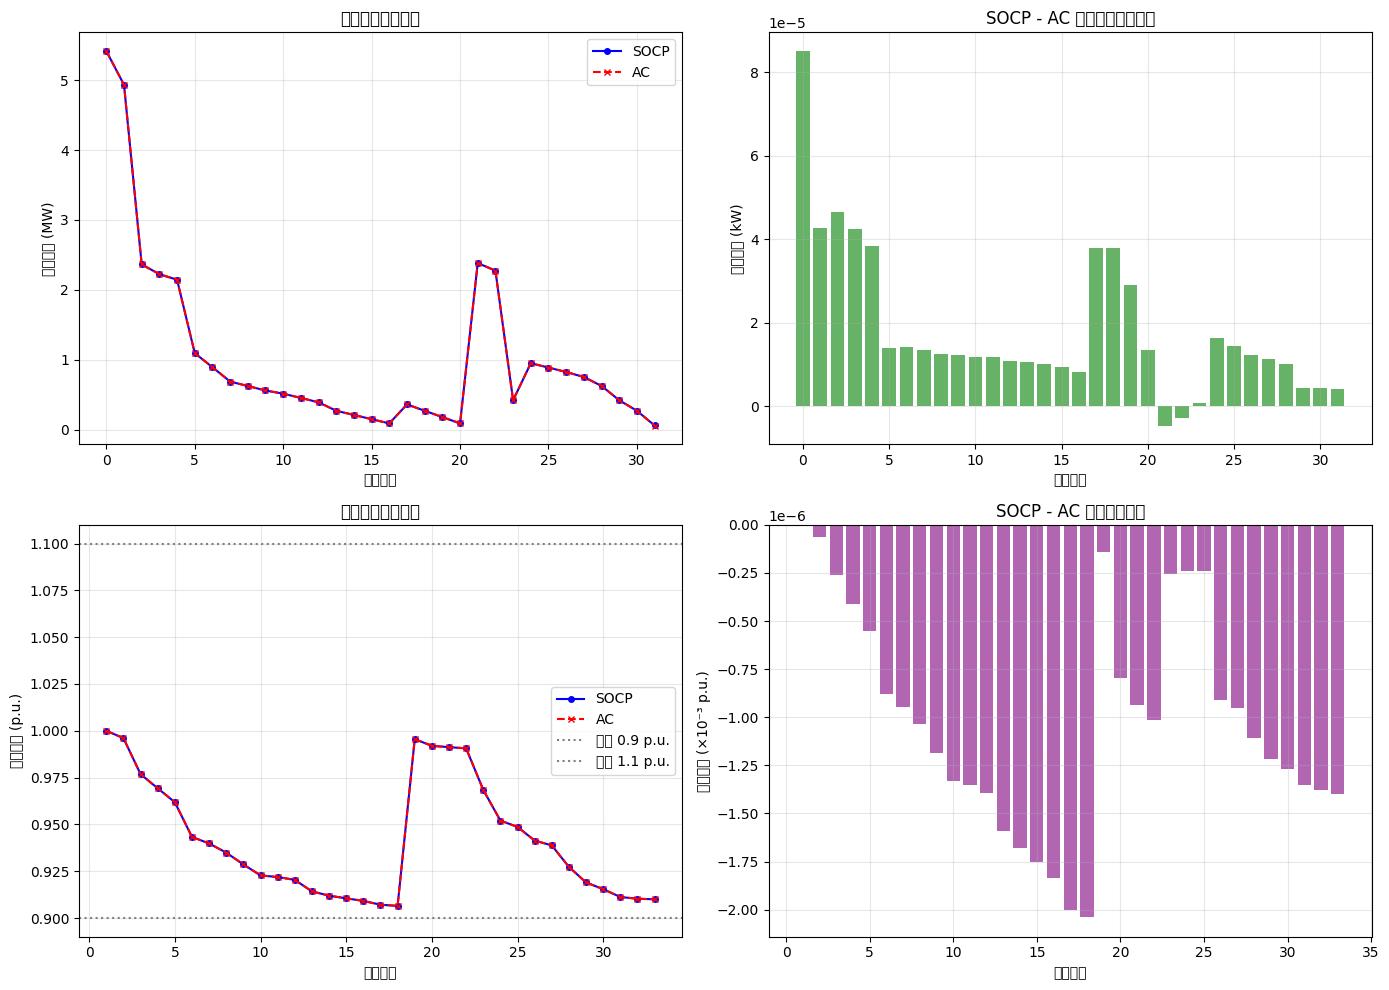


可视化结果已保存到 output/model_comparison.png


In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 苹果电脑最好用这个字体
# 创建图形
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 支路有功功率对比
ax = axes[0, 0]
branch_ids = range(len(df_compare))
ax.plot(branch_ids, df_compare['SOCP_P_MW'], 'b-o', label='SOCP', markersize=4)
ax.plot(branch_ids, df_compare['AC_P_MW'], 'r--x', label='AC', markersize=4)
ax.set_xlabel('支路编号')
ax.set_ylabel('有功功率 (MW)')
ax.set_title('支路有功功率对比')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. 支路有功功率差异
ax = axes[0, 1]
ax.bar(branch_ids, df_compare['P_diff'] * 1000, color='green', alpha=0.6)  # 转换为 kW
ax.set_xlabel('支路编号')
ax.set_ylabel('功率差异 (kW)')
ax.set_title('SOCP - AC 支路有功功率差异')
ax.grid(True, alpha=0.3)

# 3. 节点电压对比
ax = axes[1, 0]
bus_ids = df_compare_bus['bus']
ax.plot(bus_ids, df_compare_bus['SOCP_V_pu'], 'b-o', label='SOCP', markersize=4)
ax.plot(bus_ids, df_compare_bus['AC_V_pu'], 'r--x', label='AC', markersize=4)
ax.axhline(y=0.9, color='gray', linestyle=':', label='下限 0.9 p.u.')
ax.axhline(y=1.1, color='gray', linestyle=':', label='上限 1.1 p.u.')
ax.set_xlabel('节点编号')
ax.set_ylabel('电压幅值 (p.u.)')
ax.set_title('节点电压幅值对比')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. 节点电压差异
ax = axes[1, 1]
ax.bar(bus_ids, df_compare_bus['V_diff'] * 1000, color='purple', alpha=0.6)  # 转换为更小单位
ax.set_xlabel('节点编号')
ax.set_ylabel('电压差异 (×10⁻³ p.u.)')
ax.set_title('SOCP - AC 节点电压差异')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n可视化结果已保存到 output/model_comparison.png")

## 6. 松弛间隙统计

In [6]:
# 计算松弛间隙统计
print("\n松弛间隙统计：")
print("="*60)

# 支路功率差异
P_diff = df_compare['P_diff']
print(f"支路有功功率差异：")
print(f"  最大差异: {P_diff.abs().max():.6e} MW")
print(f"  平均差异: {P_diff.abs().mean():.6e} MW")
print(f"  标准差:   {P_diff.std():.6e} MW")

# 电压差异
V_diff = df_compare_bus['V_diff']
print(f"\n节点电压差异：")
print(f"  最大差异: {V_diff.abs().max():.6e} p.u.")
print(f"  平均差异: {V_diff.abs().mean():.6e} p.u.")
print(f"  标准差:   {V_diff.std():.6e} p.u.")

# 判断松弛是否紧
threshold = 1e-6
if P_diff.abs().max() < threshold and V_diff.abs().max() < threshold:
    print(f"\n结论：二阶锥松弛是紧的 (所有差异 < {threshold})")
else:
    print(f"\n结论：二阶锥松弛不紧，存在松弛间隙")

# ===================== 新增：数据中心差异统计（可选、必要输出）=====================
if df_compare_dc is not None and 'pdc_kW_diff' in df_compare_dc.columns:
    # 只统计 dc_id>=0 的单体行，排除汇总行(-1)
    df_dc_only = df_compare_dc[df_compare_dc['dc_id'] >= 0].copy()

    print("\n数据中心差异统计：")
    print("="*60)
    print("数据中心有功负荷差异（SOCP - AC）：")
    print(f"  最大差异: {df_dc_only['pdc_kW_diff'].abs().max():.6e} kW")
    print(f"  平均差异: {df_dc_only['pdc_kW_diff'].abs().mean():.6e} kW")
    print(f"  标准差:   {df_dc_only['pdc_kW_diff'].std():.6e} kW")


松弛间隙统计：
支路有功功率差异：
  最大差异: 8.507179e-08 MW
  平均差异: 1.866034e-08 MW
  标准差:   1.826964e-08 MW

节点电压差异：
  最大差异: 2.039047e-09 p.u.
  平均差异: 1.016196e-09 p.u.
  标准差:   5.765210e-10 p.u.

结论：二阶锥松弛是紧的 (所有差异 < 1e-06)

数据中心差异统计：
数据中心有功负荷差异（SOCP - AC）：
  最大差异: 4.360537e-06 kW
  平均差异: 4.360483e-06 kW
  标准差:   6.166654e-06 kW


## 7. 总结

### 主要发现：

1. **松弛紧性**：SOCP 模型的松弛是紧的，与 AC 模型的精确解几乎相同
2. **求解效率**：两个模型的求解时间相近，但 SOCP 保证全局最优
3. **实用性**：对于辐射状配电网，推荐使用 SOCP 模型

### 输出文件：

- `output/SOCP_branch_t{t}.csv`: SOCP 模型的支路结果
- `output/SOCP_bus_t{t}.csv`: SOCP 模型的节点结果
- `output/SOCP_gen_t{t}.csv`: SOCP 模型的发电机结果
- `output/AC_branch_t{t}.csv`: AC 模型的支路结果
- `output/AC_bus_t{t}.csv`: AC 模型的节点结果
- `output/AC_gen_t{t}.csv`: AC 模型的发电机结果

详细的数学模型对比请参见 `Model_Comparison.md`